In [1]:
clear all

In [2]:
from skimage import io
import nibabel as nib
import os
import numpy as np
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import matplotlib.pyplot as plt
%matplotlib inline

# Get folder

In [9]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
foldername = askdirectory() # show an "Open" dialog box and return the path to the selected file
print(foldername)

/media/sophie/b8465819-f4b4-489a-80f2-dbd85351bec1/100312/100312ss1


In [10]:
path=foldername
A=foldername.split('/')
Dataname=A[-1]
Dataname

'100312ss1'

# Open the images

In [12]:
tt = io.imread(path+'/'+Dataname+'-1000.tif') 
S=tt.shape
S

(14, 24, 103)

In [21]:
data=np.zeros([S[0],S[1],S[2],len(os.listdir(path))])
i=0
#for i in range(19980):
for j in range(len(os.listdir(path))):       
#for fn in os.listdir(path):
    #tt = io.imread(path+'/'+Dataname+'-'+str(i+1).zfill(5)+'.tif') 
    if os.path.exists(path+'/'+Dataname+'-'+str(j+10000).zfill(5)+'.tif'):
        tt = io.imread(path+'/'+Dataname+'-'+str(j+10000).zfill(5)+'.tif')
        data[:,:,:,i]=tt[:][:][:]
        i=i+1

In [22]:
S=data.shape
S

(14, 24, 103, 13569)

# Find end of onset of light and begining of offset (to align to behavior) 

Calculate average time series

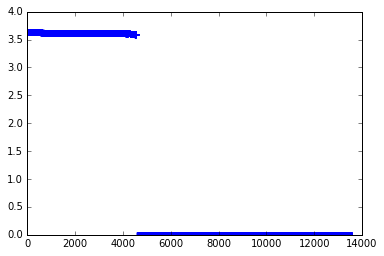

In [23]:
M=np.mean(np.mean(np.mean(data,0),0),0)
Mav=M.mean()
plt.plot(M,'+')

Get approximate on and off times

In [202]:
liston=[i for i in range(len(M)) if M[i]>Mav*0.7]
liston[0]

52

Model for fitting onset and offset

In [203]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

Model onset and find precise onset time

In [204]:
Ms=M[range(liston[0]-8,liston[0]+8)]

In [205]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [206]:
res = scipy.optimize.minimize(Sq,x0=[7,0.3,9,0.7])
ON=liston[0]-8+res.x[2]
print(ON)

52.9949570569


53


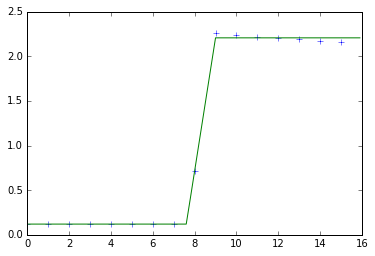

In [207]:
ONint=np.int(np.ceil(ON))
#ONint=1
print(ONint)
plt.plot(np.squeeze(M[range(liston[0]-8,liston[0]+8)]),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

Model offset and find precise offset time

In [208]:
Ms=M[range(liston[len(liston)-1]-6,liston[len(liston)-1]+6)]

In [209]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [210]:
res = scipy.optimize.minimize(Sq,x0=[6,3,8,-1])

In [211]:
OFF=liston[len(liston)-1]-6+res.x[0]
#OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

5508.2559028
5508


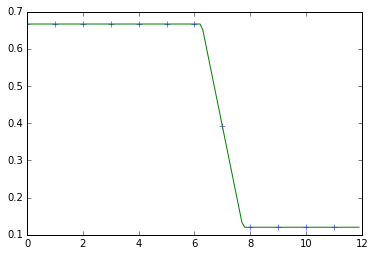

In [212]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

# Open images times

In [171]:
TimeFile='/home/sophie/Downloads/Data'+''.join([Dataname[i] for i in range(6)])+'_.csv'
print(TimeFile)

/home/sophie/Downloads/Data100389_.csv


In [172]:
Listfile = open(TimeFile, 'r')
ListTime = [line.split('\n')[0] for line in Listfile.readlines()]
Timespl=[float(ListTime[i].split(',')[2]) for i in range(1,len(ListTime))]

IOError: [Errno 2] No such file or directory: '/home/sophie/Downloads/Data100389_.csv'

# Get times corresponding to images during light on (excitation light completely on : t=0)

In [ ]:
print(ONint)
print(OFFint)
print(ON)

In [ ]:
TimeOn=[Timespl[i] for i in range(ONint,(OFFint+1))]
Tinit=(ON-(ONint-1))*(Timespl[ONint]-Timespl[ONint-1])+Timespl[ONint-1]
Toff=(OFFint+1-OFF)*(Timespl[OFFint+1]-Timespl[OFFint])+Timespl[OFFint]
Toff-Tinit

In [ ]:
Timespl[ONint]-Timespl[ONint-1]

In [ ]:
TimeOn[0]-Tinit

In [ ]:
import numpy as np

In [ ]:
Dataname

In [ ]:
TimeOnFinal=np.array(TimeOn)-Tinit

In [ ]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TimeFluoOn.mat', {'TimeFluoOn':TimeOnFinal})

In [ ]:
TotalTimeOn=Toff-Tinit

In [ ]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TotalTimeOn.mat', {'TotalTimeOn':TotalTimeOn})

# Keep only the frames for which the excitation is on and save

In [213]:
D4=np.transpose(data[:,:,:,range(ONint,(OFFint+1))],(2,1,0,3))
nim=nib.Nifti1Image(D4,np.eye(4))
nib.save(nim,'/home/sophie/Desktop/'+Dataname+'on.nii.gz')